In [3]:
import torch
import tensorflow as tf

In [4]:
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [5]:
device = torch.device('cpu')
device

import torchvision.transforms as transforms

# Normalize data with mean=0.5, std=1.0
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (1.0,))
])

In [6]:
# Data Load
download_root = './MNIST_DATASET'
train_data = MNIST(download_root, train=True, transform=mnist_transform, download=True)
test_data = MNIST(download_root, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_data,
                         batch_size=100,
                         shuffle=True)

test_loader = DataLoader(dataset=test_data, 
                         batch_size=100,
                         shuffle=True)

<h3> Defining Model 01~03.</h3>

In [7]:
# Model 01.
# Brief design: 2 Conv, 1 MAX pooling, 2FC
class CNN_Model01(nn.Module):
    def __init__(self,num_classes=10): #classes are 0~9, 10 in total.
        super(CNN_Model01, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.BatchNorm2d(32), #mean of batch
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Fully Connected Layer 
        self.fc = nn.Sequential(
            nn.Linear(14*14*64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = torch.log(F.softmax(out, dim=0))
        return out
        

In [8]:
# Model 02.
# design: 4 Conv, 2 MAX pooling, 2FC

class CNN_Model02(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Model02, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.layer2 =nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Fully Connected Layer 
        self.fc = nn.Sequential(
            nn.Linear(3136, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = torch.log(F.softmax(out, dim=0))
        return out
        

In [9]:
# Model 03(ResNet)
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layer 
        self.fc = nn.Sequential(
            nn.Linear(576, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.max_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = torch.log(F.softmax(out, dim=0))
        return out


In [11]:
#Training setup
epoch = 30
batch_size = 100

<h3> Model 01. Train & Test</>

[Epoch: 1, Minibatch:   100/600] loss: 2.856
[Epoch: 1, Minibatch:   200/600] loss: 2.639
[Epoch: 1, Minibatch:   300/600] loss: 2.574
[Epoch: 1, Minibatch:   400/600] loss: 2.554
[Epoch: 1, Minibatch:   500/600] loss: 2.530
[Epoch: 1, Minibatch:   600/600] loss: 2.520
Finished 1th Training!
Accuracy on the 10000 test images: 98.59 %
[Epoch: 2, Minibatch:   100/600] loss: 2.485
[Epoch: 2, Minibatch:   200/600] loss: 2.474
[Epoch: 2, Minibatch:   300/600] loss: 2.468
[Epoch: 2, Minibatch:   400/600] loss: 2.464
[Epoch: 2, Minibatch:   500/600] loss: 2.451
[Epoch: 2, Minibatch:   600/600] loss: 2.448
Finished 2th Training!
Accuracy on the 10000 test images: 98.39 %
[Epoch: 3, Minibatch:   100/600] loss: 2.425
[Epoch: 3, Minibatch:   200/600] loss: 2.425
[Epoch: 3, Minibatch:   300/600] loss: 2.423
[Epoch: 3, Minibatch:   400/600] loss: 2.415
[Epoch: 3, Minibatch:   500/600] loss: 2.418
[Epoch: 3, Minibatch:   600/600] loss: 2.414
Finished 3th Training!
Accuracy on the 10000 test images: 

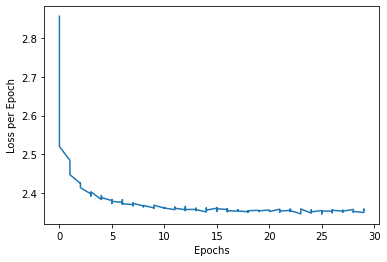

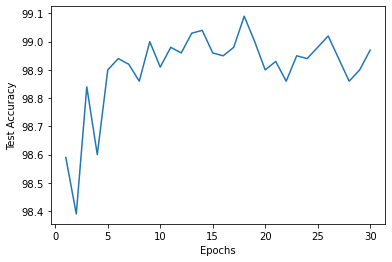

<Figure size 432x288 with 0 Axes>

In [12]:
# Train
# Model 01
model01 = CNN_Model01()
a = 0

# Lists for storing results
accuracies = []
epochs = []
loss_pr_epoch = []
# Train setup
criterion = nn.NLLLoss()
optimizer = optim.Adam(model01.parameters(), lr = 0.001)

for e in range(epoch):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model01(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        running_loss += loss.item()
        if i % 100 == 99: # print every 100 mini-batches
            epochs.append(e)
            loss_pr_epoch.append(running_loss / 100)
            print('[Epoch: %d, Minibatch: %5d/600] loss: %.3f' %
                (e + 1, i + 1, running_loss / batch_size))
            running_loss = 0.0
        a = a + 1
        
        if a == 30000:
            break
        
        correct = 0
        total = 0
        
    print("Finished {}th Training!".format(e+1))

    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model01(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy on the {} test images: {:4.2f} %'.format(test_data.data.shape[0], 100 * (correct / total)))
    accuracies.append(100 * (correct / total))

# Saving for evaluation table
model01_loss = loss_pr_epoch
model01_acc = accuracies

print("Finished Test")
torch.save(model01, 'model1.pt')

# Plot Train
plt.plot(epochs,loss_pr_epoch)
plt.xlabel("Epochs")
plt.ylabel("Loss per Epoch")
plt.savefig("Model01_Training_Loss.jpg", dpi=300)
plt.show()

# Plot Test
plt_epoch = np.array(range(1,31,1))
plt.plot(plt_epoch,accuracies)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.savefig("Model01_Test_Accuracy.jpg", dpi=300)
plt.show()

<h3> Model 02 Train & Test </>

[Epoch: 1, Minibatch: 100/600] loss: 2.801
[Epoch: 1, Minibatch: 200/600] loss: 2.568
[Epoch: 1, Minibatch: 300/600] loss: 2.513
[Epoch: 1, Minibatch: 400/600] loss: 2.472
[Epoch: 1, Minibatch: 500/600] loss: 2.457
[Epoch: 1, Minibatch: 600/600] loss: 2.443
Finished 1th Training!
Accuracy on the 10000 test images: 98.80 %
[Epoch: 2, Minibatch: 100/600] loss: 2.427
[Epoch: 2, Minibatch: 200/600] loss: 2.425
[Epoch: 2, Minibatch: 300/600] loss: 2.419
[Epoch: 2, Minibatch: 400/600] loss: 2.413
[Epoch: 2, Minibatch: 500/600] loss: 2.408
[Epoch: 2, Minibatch: 600/600] loss: 2.406
Finished 2th Training!
Accuracy on the 10000 test images: 99.11 %
[Epoch: 3, Minibatch: 100/600] loss: 2.399
[Epoch: 3, Minibatch: 200/600] loss: 2.396
[Epoch: 3, Minibatch: 300/600] loss: 2.403
[Epoch: 3, Minibatch: 400/600] loss: 2.396
[Epoch: 3, Minibatch: 500/600] loss: 2.396
[Epoch: 3, Minibatch: 600/600] loss: 2.387
Finished 3th Training!
Accuracy on the 10000 test images: 99.18 %
[Epoch: 4, Minibatch: 100/60

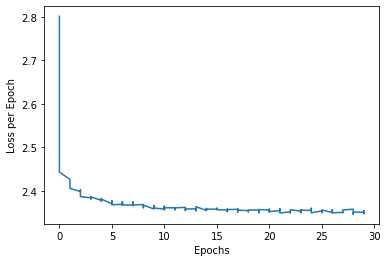

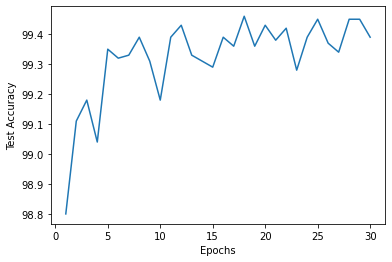

In [15]:
# Train
# Model 02
model02 = CNN_Model02()
a = 0

# Lists for storing results
accuracies = []
epochs = []
loss_pr_epoch = []
# Train setup
criterion = nn.NLLLoss()
optimizer = optim.Adam(model02.parameters(), lr = 0.001)

for e in range(epoch):
    running_loss = 0.0
    #train loop
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model02(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

       
        running_loss += loss.item()
        if i % 100 == 99: # print every 100 mini-batches
            epochs.append(e)
            loss_pr_epoch.append(running_loss / 100)
            print('[Epoch: %d, Minibatch: %3d/600] loss: %.3f' %
                (e + 1, i + 1, running_loss / batch_size))
            running_loss = 0.0
        a = a + 1
        
        if a == 30000:
            break
        
        correct = 0
        total = 0
        
    print("Finished {}th Training!".format(e+1))
    # Test loop
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model02(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy on the {} test images: {:4.2f} %'.format(test_data.data.shape[0], 100 * (correct / total)))
    accuracies.append(100 * (correct / total))
    
print("Finished Test")
torch.save(model02, 'model2.pt')

# Saving for evaluation table
model02_loss = loss_pr_epoch
model02_acc = accuracies
# Plot Train
plt.plot(epochs,loss_pr_epoch)
plt.xlabel("Epochs")
plt.ylabel("Loss per Epoch")
plt.savefig("Model02_Training_Loss.jpg", dpi=300)
plt.show()


# Plot Test
plt_epoch = np.array(range(1,31,1))
plt.plot(plt_epoch,accuracies)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.savefig("Model02_Test_Accuracy.jpg", dpi=300)
plt.show()

<h3> Model 03 Train & Test </>

Epoch [1/30], Minibatch [100/600] Loss: 2.8219
Epoch [1/30], Minibatch [200/600] Loss: 2.5182
Epoch [1/30], Minibatch [300/600] Loss: 2.4734
Epoch [1/30], Minibatch [400/600] Loss: 2.4423
Epoch [1/30], Minibatch [500/600] Loss: 2.4322
Epoch [1/30], Minibatch [600/600] Loss: 2.4219
Finished 1th Training!
Accuracy of the model on the test images: 98.95 %
Epoch [2/30], Minibatch [100/600] Loss: 2.4608
Epoch [2/30], Minibatch [200/600] Loss: 2.4420
Epoch [2/30], Minibatch [300/600] Loss: 2.4113
Epoch [2/30], Minibatch [400/600] Loss: 2.4150
Epoch [2/30], Minibatch [500/600] Loss: 2.4041
Epoch [2/30], Minibatch [600/600] Loss: 2.3983
Finished 2th Training!
Accuracy of the model on the test images: 99.28 %
Epoch [3/30], Minibatch [100/600] Loss: 2.3907
Epoch [3/30], Minibatch [200/600] Loss: 2.3889
Epoch [3/30], Minibatch [300/600] Loss: 2.3964
Epoch [3/30], Minibatch [400/600] Loss: 2.3895
Epoch [3/30], Minibatch [500/600] Loss: 2.3865
Epoch [3/30], Minibatch [600/600] Loss: 2.3871
Finished

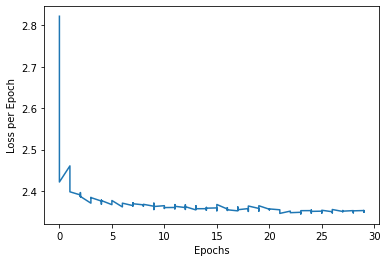

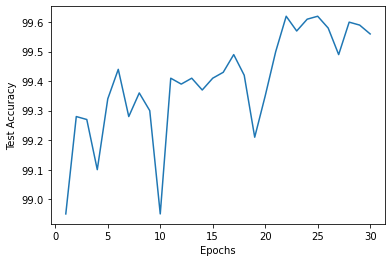

In [16]:
# Train
# Model 03
model03 = ResNet(ResidualBlock, [2, 2, 2]).to(device)
# Lists for storing results
accuracies = []
epochs = []
loss_pr_epoch = []
# Train setup
criterion = nn.NLLLoss()
optimizer = optim.Adam(model03.parameters(), lr = 0.001)

def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
# Train the model
total_step = len(train_loader)
curr_lr = 0.01
for e in range(epoch):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model03(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            epochs.append(e)
            loss_pr_epoch.append(running_loss / 100)
            print ("Epoch [{}/{}], Minibatch [{}/{}] Loss: {:.4f}"
                   .format(e+1, epoch, i+1 , '600', running_loss/batch_size))
            running_loss = 0.0

    # Decay learning rate
    if (e) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
        
    print("Finished {}th Training!".format(e+1))
    correct = 0
    total = 0
     
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model03(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    accuracies.append(100 * (correct / total))

print("Finished Test")
torch.save(model03, 'model3.pt')

# Saving for evaluation table
model03_loss = loss_pr_epoch
model03_acc = accuracies

# Plot Train
plt.plot(epochs,loss_pr_epoch)
plt.xlabel("Epochs")
plt.ylabel("Loss per Epoch")
plt.savefig("Model03_Training_Loss.jpg", dpi=300)
plt.show()

# Plot Test
plt_epoch = np.array(range(1,31,1))
plt.plot(plt_epoch,accuracies)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.savefig("Model03_Test_Accuracy.jpg", dpi=300)
plt.show()

<h3> Evaluation Table For Each Model</>

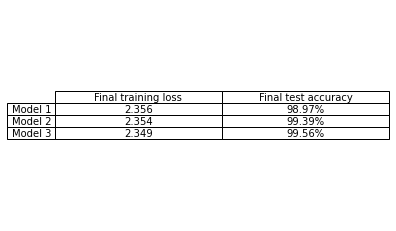

In [66]:
col = ["Final training loss", "Final test accuracy"]
row = [ "Model 1", "Model 2", "Model 3"]
data = [
        [round(model01_loss[-1],3), str(model01_acc[-1])+"%"],
        [round(model02_loss[-1],3), str(model02_acc[-1])+"%"],
        [round(model03_loss[-1],3), str(model03_acc[-1])+"%"]
        ]
fig, ax =plt.subplots(1,1)
ax.axis("tight")
ax.axis("off")
plt.table(cellText=data,
          cellLoc='center',
          rowLabels=row,
          colLabels=col,
          loc='center')
plt.savefig("Evaluation Table.jpg", dpi = 300)
plt.show()